# Convolutional Gaussian Processes
Mark van der Wilk (July 2019)

Here we show a simple example of the rectangles experiment, where we compare a normal squared exponential GP, and a convolutional GP. This is similar to the experiment in [1].

[1] Van der Wilk, Rasmussen, Hensman (2017). Convolutional Gaussian Processes. *Advances in Neural Information Processing Systems 30*.

## Generate dataset
Generate a simple dataset of rectangles. We want to classify whether they are tall or wide. **NOTE:** Here we take care to make sure that the rectangles don't touch the edge, which is different to the original paper. We do this to avoid needing to use patch weights, which are needed to correctly account for edge effects.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

from gpflow import set_trainable
from gpflow.ci_utils import is_continuous_integration

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")

# for reproducibility of this notebook:
np.random.seed(123)
tf.random.set_seed(42)

MAXITER = 2 if is_continuous_integration() else 100
NUM_TRAIN_DATA = (
    5 if is_continuous_integration() else 100
)  # This is less than in the original rectangles dataset
NUM_TEST_DATA = 7 if is_continuous_integration() else 300
H = W = 14  # width and height. In the original paper this is 28
IMAGE_SHAPE = [H, W]

2022-03-08 11:42:31.519853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 11:42:31.519882: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def affine_scalar_bijector(shift=None, scale=None):
    scale_bijector = tfp.bijectors.Scale(scale) if scale else tfp.bijectors.Identity()
    shift_bijector = tfp.bijectors.Shift(shift) if shift else tfp.bijectors.Identity()
    return shift_bijector(scale_bijector)


def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (
        d.reshape(num, w * h).astype(gpflow.config.default_float()),
        Y.astype(gpflow.config.default_float()),
    )

In [3]:
X, Y = data = make_rectangles_dataset(NUM_TRAIN_DATA, *IMAGE_SHAPE)
Xt, Yt = test_data = make_rectangles_dataset(NUM_TEST_DATA, *IMAGE_SHAPE)

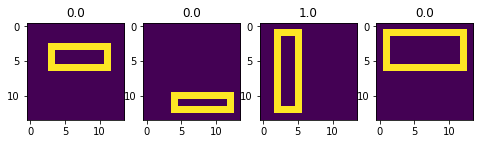

In [4]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(*IMAGE_SHAPE))
    plt.title(Y[i, 0])

## Squared Exponential kernel

In [5]:
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X.copy()),
)

2022-03-08 11:42:33.771096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 11:42:33.771125: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 11:42:33.771145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (48ab5453dcce): /proc/driver/nvidia/version does not exist
2022-03-08 11:42:33.771415: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
rbf_training_loss_closure = rbf_m.training_loss_closure(data, compile=True)
rbf_elbo = lambda: -rbf_training_loss_closure().numpy()
print("RBF elbo before training: %.4e" % rbf_elbo())

2022-03-08 11:42:37.397166: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-03-08 11:42:37.560508: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


RBF elbo before training: -9.9408e+01


In [7]:
set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    rbf_training_loss_closure,
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5152     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94077D+01    |proj g|=  1.77693D+01

At iterate    1    f=  8.27056D+01    |proj g|=  1.08235D+01

At iterate    2    f=  7.10286D+01    |proj g|=  2.52642D+00

At iterate    3    f=  6.96128D+01    |proj g|=  9.52086D-01

At iterate    4    f=  6.91601D+01    |proj g|=  2.98596D-01

At iterate    5    f=  6.90683D+01    |proj g|=  4.57667D-01

At iterate    6    f=  6.87999D+01    |proj g|=  8.48569D-01

At iterate    7    f=  6.87526D+01    |proj g|=  1.00002D+00

At iterate    8    f=  6.85857D+01    |proj g|=  1.28576D+00

At iterate    9    f=  6.81708D+01    |proj g|=  2.04265D+00

At iterate   10    f=  6.58595D+01    |proj g|=  1.34225D+00

At iterate   11    f=  6.47617D+01    |proj g|=  9.21923D-01

At iterate   12    f=  6.37115D+01    |proj g|=  7.98398D-01

At iterate   13    f=  6.3

 This problem is unconstrained.


In [8]:
train_acc = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())

Train acc: 100.0%
Test acc : 68.33333333333333%
RBF elbo after training: -6.0371e+01


## Convolutional kernel

In [9]:
f64 = lambda x: np.array(x, dtype=np.float64)
positive_with_min = lambda: affine_scalar_bijector(shift=f64(1e-4))(tfp.bijectors.Softplus())
constrained = lambda: affine_scalar_bijector(shift=f64(1e-4), scale=f64(100.0))(
    tfp.bijectors.Sigmoid()
)
max_abs_1 = lambda: affine_scalar_bijector(shift=f64(-2.0), scale=f64(4.0))(tfp.bijectors.Sigmoid())

patch_shape = [3, 3]
conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, patch_shape)
conv_k.base_kernel.lengthscales = gpflow.Parameter(1.0, transform=positive_with_min())
# Weight scale and variance are non-identifiable. We also need to prevent variance from shooting off crazily.
conv_k.base_kernel.variance = gpflow.Parameter(1.0, transform=constrained())
conv_k.weights = gpflow.Parameter(conv_k.weights.numpy(), transform=max_abs_1())
conv_f = gpflow.inducing_variables.InducingPatches(
    np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0)
)

In [10]:
conv_m = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

In [11]:
set_trainable(conv_m.inducing_variable, False)
set_trainable(conv_m.kernel.base_kernel.variance, False)
set_trainable(conv_m.kernel.weights, False)

In [12]:
conv_training_loss_closure = conv_m.training_loss_closure(data, compile=True)
conv_elbo = lambda: -conv_training_loss_closure().numpy()
print("conv elbo before training: %.4e" % conv_elbo())

conv elbo before training: -8.7271e+01


In [13]:
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER / 10},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1081     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72706D+01    |proj g|=  3.34786D+01

At iterate    1    f=  7.06198D+01    |proj g|=  1.23134D+01

At iterate    2    f=  7.03607D+01    |proj g|=  6.56137D+00

At iterate    3    f=  6.98680D+01    |proj g|=  2.96447D+00


 This problem is unconstrained.



At iterate    4    f=  6.93739D+01    |proj g|=  2.88465D+00

At iterate    5    f=  6.88717D+01    |proj g|=  5.27202D+00

At iterate    6    f=  6.60134D+01    |proj g|=  1.11323D+01

At iterate    7    f=  6.51602D+01    |proj g|=  3.43289D+00



At iterate    8    f=  6.49795D+01    |proj g|=  9.75563D-01

At iterate    9    f=  6.48808D+01    |proj g|=  9.60694D-01

7.821 iter/s
At iterate   10    f=  6.48453D+01    |proj g|=  1.39257D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1081     10     11      1     0     0   1.393D+00   6.485D+01
  F =   64.845328136876162     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [14]:
set_trainable(conv_m.kernel.base_kernel.variance, True)
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("conv elbo after training: %.4e" % conv_elbo())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1082     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48453D+01    |proj g|=  3.53996D+00

At iterate    1    f=  6.24919D+01    |proj g|=  7.35357D+00

At iterate    2    f=  6.23531D+01    |proj g|=  7.58264D+00



At iterate    3    f=  6.04166D+01    |proj g|=  1.58157D+01



At iterate    4    f=  5.88887D+01    |proj g|=  2.48005D+01

At iterate    5    f=  5.63927D+01    |proj g|=  4.28536D+01

At iterate    6    f=  5.02144D+01    |proj g|=  1.04313D+02



At iterate    7    f=  4.44685D+01    |proj g|=  8.74280D+01

At iterate    8    f=  3.92359D+01    |proj g|=  3.11481D+01



At iterate    9    f=  3.74686D+01    |proj g|=  3.06073D+01

At iterate   10    f=  3.68864D+01    |proj g|=  4.40037D+01

At iterate   11    f=  3.60668D+01    |proj g|=  7.87412D+00

At iterate   12    f=  3.58935D+01    |proj g|=  1.41535D+01



At iterate   13    f=  3.45651D+01    |proj g|=  7.04865D+01

At iterate   14    f=  3.13752D+01    |proj g|=  4.56939D+01

At iterate   15    f=  3.02012D+01    |proj g|=  2.86627D+01

At iterate   16    f=  2.96655D+01    |proj g|=  1.60272D+01



At iterate   17    f=  2.94558D+01    |proj g|=  8.24031D+00

At iterate   18    f=  2.93105D+01    |proj g|=  2.25261D+00

At iterate   19    f=  2.90992D+01    |proj g|=  5.73397D+00

At iterate   20    f=  2.87163D+01    |proj g|=  1.55953D+01



At iterate   21    f=  2.81823D+01    |proj g|=  2.54265D+01

At iterate   22    f=  2.80343D+01    |proj g|=  2.19902D+01

At iterate   23    f=  2.79432D+01    |proj g|=  1.41609D+01



At iterate   24    f=  2.78263D+01    |proj g|=  2.44911D+00

At iterate   25    f=  2.78000D+01    |proj g|=  1.18706D+00

At iterate   26    f=  2.77623D+01    |proj g|=  3.27247D+00

At iterate   27    f=  2.76356D+01    |proj g|=  5.23204D+00



At iterate   28    f=  2.74130D+01    |proj g|=  6.84226D+00

At iterate   29    f=  2.72099D+01    |proj g|=  2.39793D+00

At iterate   30    f=  2.71505D+01    |proj g|=  8.87291D-01

At iterate   31    f=  2.71225D+01    |proj g|=  1.25368D+00



At iterate   32    f=  2.70691D+01    |proj g|=  3.44551D+00

At iterate   33    f=  2.70246D+01    |proj g|=  3.99899D+00

At iterate   34    f=  2.70165D+01    |proj g|=  1.66840D+00



At iterate   35    f=  2.69736D+01    |proj g|=  1.96735D-01

At iterate   36    f=  2.69568D+01    |proj g|=  4.38151D+00

At iterate   37    f=  2.69408D+01    |proj g|=  1.61116D+00

At iterate   38    f=  2.69308D+01    |proj g|=  1.04302D+00



At iterate   39    f=  2.68977D+01    |proj g|=  1.50422D+00

At iterate   40    f=  2.68704D+01    |proj g|=  2.03393D+00

At iterate   41    f=  2.68478D+01    |proj g|=  7.74727D-01

At iterate   42    f=  2.68370D+01    |proj g|=  6.68973D-01



At iterate   43    f=  2.68312D+01    |proj g|=  1.17495D+00

At iterate   44    f=  2.68205D+01    |proj g|=  1.40366D+00

At iterate   45    f=  2.68164D+01    |proj g|=  2.93858D+00



At iterate   46    f=  2.68066D+01    |proj g|=  1.14149D+00

At iterate   47    f=  2.68038D+01    |proj g|=  2.29233D-01

At iterate   48    f=  2.68031D+01    |proj g|=  6.60555D-02

At iterate   49    f=  2.68025D+01    |proj g|=  6.92373D-01



At iterate   50    f=  2.68010D+01    |proj g|=  7.83843D-01

At iterate   51    f=  2.67992D+01    |proj g|=  2.75329D+00

At iterate   52    f=  2.67965D+01    |proj g|=  1.09870D+00

At iterate   53    f=  2.67954D+01    |proj g|=  1.38041D-01



At iterate   54    f=  2.67951D+01    |proj g|=  1.82746D-01

At iterate   55    f=  2.67943D+01    |proj g|=  2.35941D-01

At iterate   56    f=  2.67915D+01    |proj g|=  1.36116D+00



At iterate   57    f=  2.67888D+01    |proj g|=  1.44414D+00

At iterate   58    f=  2.67867D+01    |proj g|=  6.69279D-01

At iterate   59    f=  2.67852D+01    |proj g|=  2.49102D-01

At iterate   60    f=  2.67849D+01    |proj g|=  1.30017D-01



At iterate   61    f=  2.67838D+01    |proj g|=  3.46225D-01

At iterate   62    f=  2.67818D+01    |proj g|=  7.67397D-01

At iterate   63    f=  2.67784D+01    |proj g|=  9.00620D-01



At iterate   64    f=  2.67780D+01    |proj g|=  1.20318D+00

At iterate   65    f=  2.67748D+01    |proj g|=  8.03691D-01

At iterate   66    f=  2.67725D+01    |proj g|=  9.45357D-02



At iterate   67    f=  2.67716D+01    |proj g|=  2.91828D-01

At iterate   68    f=  2.67709D+01    |proj g|=  2.11173D-01

At iterate   69    f=  2.67707D+01    |proj g|=  7.82288D-01



At iterate   70    f=  2.67699D+01    |proj g|=  4.70435D-01

At iterate   71    f=  2.67687D+01    |proj g|=  7.64111D-02

At iterate   72    f=  2.67676D+01    |proj g|=  3.16495D-01

At iterate   73    f=  2.67667D+01    |proj g|=  4.35490D-01



At iterate   74    f=  2.67662D+01    |proj g|=  8.69336D-01

At iterate   75    f=  2.67653D+01    |proj g|=  1.23714D+00

At iterate   76    f=  2.67642D+01    |proj g|=  5.34858D-01

At iterate   77    f=  2.67634D+01    |proj g|=  4.68922D-02



At iterate   78    f=  2.67632D+01    |proj g|=  1.28713D-01

At iterate   79    f=  2.67626D+01    |proj g|=  1.92004D-01

At iterate   80    f=  2.67625D+01    |proj g|=  5.90015D-01



At iterate   81    f=  2.67616D+01    |proj g|=  3.65632D-01

At iterate   82    f=  2.67614D+01    |proj g|=  3.15288D-01

At iterate   83    f=  2.67611D+01    |proj g|=  1.90900D-01

At iterate   84    f=  2.67607D+01    |proj g|=  1.49062D-01



At iterate   85    f=  2.67587D+01    |proj g|=  1.99628D-01

At iterate   86    f=  2.67574D+01    |proj g|=  4.47131D-01

At iterate   87    f=  2.67565D+01    |proj g|=  6.65020D-01

At iterate   88    f=  2.67561D+01    |proj g|=  2.54831D-01



At iterate   89    f=  2.67560D+01    |proj g|=  1.09139D-01

At iterate   90    f=  2.67558D+01    |proj g|=  1.25322D-01

At iterate   91    f=  2.67555D+01    |proj g|=  2.58350D-01



At iterate   92    f=  2.67551D+01    |proj g|=  3.97942D-01

At iterate   93    f=  2.67549D+01    |proj g|=  4.57127D-01

At iterate   94    f=  2.67545D+01    |proj g|=  1.87957D-01



At iterate   95    f=  2.67543D+01    |proj g|=  8.32295D-02

At iterate   96    f=  2.67541D+01    |proj g|=  1.60112D-01

At iterate   97    f=  2.67537D+01    |proj g|=  1.91034D-01

At iterate   98    f=  2.67525D+01    |proj g|=  1.92840D-01



At iterate   99    f=  2.67524D+01    |proj g|=  5.75753D-01

At iterate  100    f=  2.67515D+01    |proj g|=  1.69093D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1082    100    114      1     0     0   1.691D-01   2.675D+01
  F =   26.751529582590862     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Train acc: 100.0%
Test acc : 99.0%
conv elbo after training: -2.6752e+01


In [15]:
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("conv elbo after training: %.4e" % conv_elbo())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1082     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67515D+01    |proj g|=  1.69093D-01

At iterate    1    f=  2.67515D+01    |proj g|=  1.37900D-01



At iterate    2    f=  2.67514D+01    |proj g|=  8.60471D-02

At iterate    3    f=  2.67508D+01    |proj g|=  5.47512D-01

At iterate    4    f=  2.67504D+01    |proj g|=  5.26377D-01



At iterate    5    f=  2.67503D+01    |proj g|=  3.97805D-01

At iterate    6    f=  2.67502D+01    |proj g|=  8.48160D-02

At iterate    7    f=  2.67501D+01    |proj g|=  1.21250D-01

At iterate    8    f=  2.67501D+01    |proj g|=  2.78598D-01



At iterate    9    f=  2.67500D+01    |proj g|=  5.40241D-01

At iterate   10    f=  2.67497D+01    |proj g|=  7.78623D-01

At iterate   11    f=  2.67494D+01    |proj g|=  7.93596D-01

At iterate   12    f=  2.67488D+01    |proj g|=  5.29013D-01



At iterate   13    f=  2.67482D+01    |proj g|=  1.29972D-01

At iterate   14    f=  2.67480D+01    |proj g|=  1.45985D-01

At iterate   15    f=  2.67479D+01    |proj g|=  1.78977D-01

At iterate   16    f=  2.67477D+01    |proj g|=  1.47402D-01



At iterate   17    f=  2.67471D+01    |proj g|=  4.41252D-01

At iterate   18    f=  2.67468D+01    |proj g|=  2.15269D-01

At iterate   19    f=  2.67466D+01    |proj g|=  1.62751D-01



At iterate   20    f=  2.67465D+01    |proj g|=  2.49423D-01

At iterate   21    f=  2.67464D+01    |proj g|=  8.92598D-02

At iterate   22    f=  2.67464D+01    |proj g|=  2.02544D-02

At iterate   23    f=  2.67464D+01    |proj g|=  2.46113D-02



At iterate   24    f=  2.67463D+01    |proj g|=  1.43124D-01

At iterate   25    f=  2.67462D+01    |proj g|=  1.81130D-01

At iterate   26    f=  2.67461D+01    |proj g|=  2.62645D-01

At iterate   27    f=  2.67460D+01    |proj g|=  8.41146D-02



At iterate   28    f=  2.67460D+01    |proj g|=  1.53672D-02

At iterate   29    f=  2.67460D+01    |proj g|=  6.27980D-02

At iterate   30    f=  2.67460D+01    |proj g|=  1.05202D-01

At iterate   31    f=  2.67460D+01    |proj g|=  7.63448D-02



At iterate   32    f=  2.67459D+01    |proj g|=  8.68838D-02

At iterate   33    f=  2.67459D+01    |proj g|=  4.66420D-02

At iterate   34    f=  2.67459D+01    |proj g|=  5.88607D-02

At iterate   35    f=  2.67459D+01    |proj g|=  7.00853D-02



At iterate   36    f=  2.67459D+01    |proj g|=  1.11523D-01

At iterate   37    f=  2.67458D+01    |proj g|=  8.99448D-02

At iterate   38    f=  2.67458D+01    |proj g|=  3.33641D-02

At iterate   39    f=  2.67458D+01    |proj g|=  3.63745D-02



At iterate   40    f=  2.67458D+01    |proj g|=  8.40230D-02

At iterate   41    f=  2.67458D+01    |proj g|=  1.24401D-01

At iterate   42    f=  2.67458D+01    |proj g|=  1.03772D-01



At iterate   43    f=  2.67458D+01    |proj g|=  1.17965D-01

At iterate   44    f=  2.67458D+01    |proj g|=  3.88717D-02

At iterate   45    f=  2.67458D+01    |proj g|=  1.48371D-02

At iterate   46    f=  2.67457D+01    |proj g|=  2.40394D-02



At iterate   47    f=  2.67457D+01    |proj g|=  5.86253D-02

At iterate   48    f=  2.67457D+01    |proj g|=  8.15025D-02

At iterate   49    f=  2.67457D+01    |proj g|=  2.10361D-01

At iterate   50    f=  2.67457D+01    |proj g|=  1.11871D-01



At iterate   51    f=  2.67457D+01    |proj g|=  1.29212D-02

At iterate   52    f=  2.67456D+01    |proj g|=  5.69213D-02

At iterate   53    f=  2.67456D+01    |proj g|=  6.67736D-02

At iterate   54    f=  2.67456D+01    |proj g|=  1.53114D-01



At iterate   55    f=  2.67456D+01    |proj g|=  5.53113D-02

At iterate   56    f=  2.67456D+01    |proj g|=  9.88720D-02

At iterate   57    f=  2.67455D+01    |proj g|=  8.54282D-02

At iterate   58    f=  2.67455D+01    |proj g|=  5.18723D-02



At iterate   59    f=  2.67453D+01    |proj g|=  9.13463D-02

At iterate   60    f=  2.67452D+01    |proj g|=  2.12546D-01

At iterate   61    f=  2.67451D+01    |proj g|=  3.66273D-01

At iterate   62    f=  2.67450D+01    |proj g|=  1.79668D-01

At iterate   63    f=  2.67450D+01    |proj g|=  6.63265D-02



At iterate   64    f=  2.67450D+01    |proj g|=  4.63633D-02

At iterate   65    f=  2.67449D+01    |proj g|=  1.33698D-01

At iterate   66    f=  2.67448D+01    |proj g|=  1.32009D-01

At iterate   67    f=  2.67448D+01    |proj g|=  4.03919D-01



At iterate   68    f=  2.67447D+01    |proj g|=  2.18703D-01

At iterate   69    f=  2.67446D+01    |proj g|=  8.87510D-02

At iterate   70    f=  2.67444D+01    |proj g|=  1.27641D-01

At iterate   71    f=  2.67442D+01    |proj g|=  2.61736D-01



At iterate   72    f=  2.67439D+01    |proj g|=  2.96729D-01

At iterate   73    f=  2.67437D+01    |proj g|=  5.48048D-01

At iterate   74    f=  2.67434D+01    |proj g|=  2.69751D-01



At iterate   75    f=  2.67432D+01    |proj g|=  1.25938D-01

At iterate   76    f=  2.67430D+01    |proj g|=  2.49097D-01

At iterate   77    f=  2.67429D+01    |proj g|=  3.42026D-01

At iterate   78    f=  2.67426D+01    |proj g|=  2.04469D-01



At iterate   79    f=  2.67423D+01    |proj g|=  3.63790D-01

At iterate   80    f=  2.67421D+01    |proj g|=  6.91970D-02

At iterate   81    f=  2.67420D+01    |proj g|=  1.16793D-01

At iterate   82    f=  2.67419D+01    |proj g|=  1.35382D-01



At iterate   83    f=  2.67414D+01    |proj g|=  2.67863D-01

At iterate   84    f=  2.67409D+01    |proj g|=  4.74994D-01

At iterate   85    f=  2.67407D+01    |proj g|=  1.56351D-01



At iterate   86    f=  2.67405D+01    |proj g|=  6.13580D-02

At iterate   87    f=  2.67403D+01    |proj g|=  1.04075D-01

At iterate   88    f=  2.67399D+01    |proj g|=  2.95617D-01

At iterate   89    f=  2.67391D+01    |proj g|=  2.04370D-01



At iterate   90    f=  2.67387D+01    |proj g|=  9.60173D-01

At iterate   91    f=  2.67383D+01    |proj g|=  2.17469D-01

At iterate   92    f=  2.67381D+01    |proj g|=  7.59224D-02

At iterate   93    f=  2.67379D+01    |proj g|=  1.95956D-01



At iterate   94    f=  2.67376D+01    |proj g|=  2.78171D-01

At iterate   95    f=  2.67373D+01    |proj g|=  2.41660D-01

At iterate   96    f=  2.67372D+01    |proj g|=  4.68747D-01



At iterate   97    f=  2.67369D+01    |proj g|=  2.12805D-01

At iterate   98    f=  2.67366D+01    |proj g|=  9.61780D-02

At iterate   99    f=  2.67363D+01    |proj g|=  1.23638D-01

At iterate  100    f=  2.67360D+01    |proj g|=  1.10330D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1082    100    111      1     0     0   1.103D-01   2.674D+01
  F =   26.736043165177456     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Train acc: 100.0%
Test acc : 99.0%
conv elbo after training: -2.6736e+01


In [16]:
set_trainable(conv_m.kernel.weights, True)
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("conv elbo after training: %.4e" % conv_elbo())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1226     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67360D+01    |proj g|=  3.16039D-01

At iterate    1    f=  2.65474D+01    |proj g|=  2.05739D+01


 This problem is unconstrained.



At iterate    2    f=  2.49378D+01    |proj g|=  1.46693D+01

At iterate    3    f=  2.43009D+01    |proj g|=  3.70412D+01

At iterate    4    f=  2.22420D+01    |proj g|=  6.95732D+00



At iterate    5    f=  2.15912D+01    |proj g|=  1.05597D+00

At iterate    6    f=  2.11584D+01    |proj g|=  9.99879D-01



At iterate    7    f=  1.96358D+01    |proj g|=  9.20733D+00

At iterate    8    f=  1.90208D+01    |proj g|=  1.04027D+00

At iterate    9    f=  1.85047D+01    |proj g|=  2.39000D+00

At iterate   10    f=  1.82374D+01    |proj g|=  1.33520D+00



At iterate   11    f=  1.79114D+01    |proj g|=  5.40389D-01

At iterate   12    f=  1.79031D+01    |proj g|=  3.62414D+00



At iterate   13    f=  1.78035D+01    |proj g|=  1.73738D+00

At iterate   14    f=  1.77329D+01    |proj g|=  4.72931D+00



At iterate   15    f=  1.77049D+01    |proj g|=  1.80459D+00

At iterate   16    f=  1.76982D+01    |proj g|=  2.96590D-01

At iterate   17    f=  1.76931D+01    |proj g|=  3.35757D-01



At iterate   18    f=  1.76848D+01    |proj g|=  4.30043D-01

At iterate   19    f=  1.76489D+01    |proj g|=  3.13644D-01

At iterate   20    f=  1.76112D+01    |proj g|=  3.34715D-01



At iterate   21    f=  1.75893D+01    |proj g|=  3.30122D-01

At iterate   22    f=  1.75565D+01    |proj g|=  6.81429D-01



At iterate   23    f=  1.75471D+01    |proj g|=  3.08014D+00

At iterate   24    f=  1.75336D+01    |proj g|=  8.58809D-01

At iterate   25    f=  1.75299D+01    |proj g|=  3.31940D-01



At iterate   26    f=  1.75254D+01    |proj g|=  2.53066D-01

At iterate   27    f=  1.75211D+01    |proj g|=  1.49449D+00

At iterate   28    f=  1.75155D+01    |proj g|=  1.18743D+00

At iterate   29    f=  1.75099D+01    |proj g|=  4.41971D-01



At iterate   30    f=  1.75061D+01    |proj g|=  4.99389D-01

At iterate   31    f=  1.75019D+01    |proj g|=  3.35700D-01

At iterate   32    f=  1.74865D+01    |proj g|=  6.54490D-01

At iterate   33    f=  1.74747D+01    |proj g|=  4.98794D-01



At iterate   34    f=  1.74733D+01    |proj g|=  8.07354D-01

At iterate   35    f=  1.74661D+01    |proj g|=  5.78892D-01

At iterate   36    f=  1.74638D+01    |proj g|=  7.96601D-01



At iterate   37    f=  1.74608D+01    |proj g|=  4.83646D-01

At iterate   38    f=  1.74561D+01    |proj g|=  6.81912D-01

At iterate   39    f=  1.74491D+01    |proj g|=  6.07960D-01



At iterate   40    f=  1.74473D+01    |proj g|=  2.47063D+00

At iterate   41    f=  1.74376D+01    |proj g|=  1.62870D+00

At iterate   42    f=  1.74282D+01    |proj g|=  5.29646D-01



At iterate   43    f=  1.74217D+01    |proj g|=  3.32963D-01

At iterate   44    f=  1.74159D+01    |proj g|=  6.69418D-01

At iterate   45    f=  1.74050D+01    |proj g|=  7.19126D-01



At iterate   46    f=  1.74034D+01    |proj g|=  1.10205D+00

At iterate   47    f=  1.73949D+01    |proj g|=  2.82657D-01

At iterate   48    f=  1.73897D+01    |proj g|=  4.17046D-01



At iterate   49    f=  1.73854D+01    |proj g|=  1.12026D+00

At iterate   50    f=  1.73782D+01    |proj g|=  1.09449D+00



At iterate   51    f=  1.73734D+01    |proj g|=  1.51179D+00

At iterate   52    f=  1.73621D+01    |proj g|=  4.69174D-01

At iterate   53    f=  1.73529D+01    |proj g|=  2.72591D-01

At iterate   54    f=  1.73433D+01    |proj g|=  3.80716D-01



At iterate   55    f=  1.73308D+01    |proj g|=  1.00524D+00

At iterate   56    f=  1.73105D+01    |proj g|=  3.94670D-01

At iterate   57    f=  1.72998D+01    |proj g|=  2.42201D-01



At iterate   58    f=  1.72955D+01    |proj g|=  1.51572D+00

At iterate   59    f=  1.72883D+01    |proj g|=  3.72257D-01

At iterate   60    f=  1.72842D+01    |proj g|=  4.16533D-01

At iterate   61    f=  1.72734D+01    |proj g|=  1.00592D+00



At iterate   62    f=  1.72659D+01    |proj g|=  1.96583D+00

At iterate   63    f=  1.72595D+01    |proj g|=  1.17757D+00

At iterate   64    f=  1.72561D+01    |proj g|=  6.16319D-01



At iterate   65    f=  1.72495D+01    |proj g|=  6.90458D-01

At iterate   66    f=  1.72429D+01    |proj g|=  7.12331D-01

At iterate   67    f=  1.72323D+01    |proj g|=  7.07348D-01



At iterate   68    f=  1.72267D+01    |proj g|=  8.91587D-01

At iterate   69    f=  1.72251D+01    |proj g|=  3.82632D+00

At iterate   70    f=  1.72126D+01    |proj g|=  1.29960D+00



At iterate   71    f=  1.72068D+01    |proj g|=  1.24160D-01

At iterate   72    f=  1.72014D+01    |proj g|=  6.39824D-01

At iterate   73    f=  1.71980D+01    |proj g|=  4.52916D-01



At iterate   74    f=  1.71961D+01    |proj g|=  9.89745D-01

At iterate   75    f=  1.71939D+01    |proj g|=  5.73695D-01

At iterate   76    f=  1.71883D+01    |proj g|=  1.03127D+00

At iterate   77    f=  1.71808D+01    |proj g|=  1.36910D+00



At iterate   78    f=  1.71719D+01    |proj g|=  1.11912D+00

At iterate   79    f=  1.71674D+01    |proj g|=  1.50374D+00

At iterate   80    f=  1.71604D+01    |proj g|=  6.31966D-01



At iterate   81    f=  1.71566D+01    |proj g|=  4.01770D-01

At iterate   82    f=  1.71535D+01    |proj g|=  5.25877D-01

At iterate   83    f=  1.71488D+01    |proj g|=  4.61630D-01



At iterate   84    f=  1.71472D+01    |proj g|=  8.39867D-01

At iterate   85    f=  1.71419D+01    |proj g|=  5.58367D-01

At iterate   86    f=  1.71376D+01    |proj g|=  8.27413D-01



At iterate   87    f=  1.71364D+01    |proj g|=  4.25543D-01

At iterate   88    f=  1.71356D+01    |proj g|=  1.76455D-01

At iterate   89    f=  1.71348D+01    |proj g|=  5.95972D-02



At iterate   90    f=  1.71328D+01    |proj g|=  2.43585D-01

At iterate   91    f=  1.71304D+01    |proj g|=  3.53293D-01

At iterate   92    f=  1.71278D+01    |proj g|=  6.05814D-01

At iterate   93    f=  1.71255D+01    |proj g|=  2.25073D-01



At iterate   94    f=  1.71242D+01    |proj g|=  1.62685D-01

At iterate   95    f=  1.71225D+01    |proj g|=  3.17535D-01



At iterate   96    f=  1.71217D+01    |proj g|=  9.61128D-01

At iterate   97    f=  1.71199D+01    |proj g|=  6.43166D-01

At iterate   98    f=  1.71174D+01    |proj g|=  6.89484D-01

At iterate   99    f=  1.71161D+01    |proj g|=  5.39661D-01



At iterate  100    f=  1.71153D+01    |proj g|=  4.58137D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1226    100    119      1     0     0   4.581D-01   1.712D+01
  F =   17.115305664651387     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Train acc: 100.0%
Test acc : 95.66666666666667%
conv elbo after training: -1.7115e+01


In [17]:
gpflow.utilities.print_summary(rbf_m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.566551769311365
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.7512917930399103
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 196)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[-5.78241751e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[6.44747990e-01, 0.00000000e+00, 0.00000000e+00..."


In [18]:
gpflow.utilities.print_summary(conv_m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.base_kernel.variance,Parameter,Sigmoid + Chain,,True,(),float64,99.97964934664145
SVGP.kernel.base_kernel.lengthscales,Parameter,Softplus + Chain,,True,(),float64,0.6222711997934419
SVGP.kernel.weights,Parameter,Sigmoid + Chain,,True,"(144,)",float64,"[0.15425583, 0.29994608, 0.38374455..."
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(45, 9)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(45, 1)",float64,[[0.01160571...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 45, 45)",float64,"[[[7.30566546e-02, 0.00000000e+00, 0.00000000e+00..."


## Conclusion
The convolutional kernel performs much better in this simple task. It demonstrates non-local generalization of the strong assumptions in the kernel.